# Zero to Hero

## 2.01 Optimizacion Bayesiana

### Advertencia

El uso del método de Optimización Bayesiana para la optimización de hiperparámetros en modelos predictivos tiene menos de una década.
Entender los fundamentos de la O.B. requieren de una sólida formación matemática y **no** son el objetivo de esta asignatura.
Para quienes deseen aventurarse a los detalles técnicos:
* El paper original de la libreria mlrMBO (año 2018 )   https://arxiv.org/pdf/1703.03373.pdf
* El método de Kriging , tal cual se deriva del uso original, en este pequeño libro de 106 páginas "Basic Steps in Geostatistics: The Variogram and Kriging" https://www.pdfdrive.com/basic-steps-in-geostatistics-the-variogram-and-kriging-e187336318.html

### El código

In [1]:
#Ejemplo de optimizacion bayesiana, univariada

#limpio la memoria
rm( list=ls() )  #remove all objects
gc()             #garbage collection

require("data.table")
#paquetes necesarios para la Bayesian Optimization
require("DiceKriging")
require("mlrMBO")

options(repr.plot.width=20, repr.plot.height=10)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,614815,32.9,1321231,70.6,1321231,70.6
Vcells,1093650,8.4,8388608,64.0,1632983,12.5


Loading required package: data.table

Loading required package: DiceKriging

Loading required package: mlrMBO

Loading required package: mlr

Loading required package: ParamHelpers

Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.

Loading required package: smoof

Loading required package: checkmate


Attaching package: 'checkmate'


The following object is masked from 'package:DiceKriging':

    checkNames




### Defino la funcion a optimizar, un polinomio de grado 4

In [6]:
func_univariada01  <- function( x )
{
  y  <- -2 * (x+13) * (x-3) * (x-7) * (x-19)

  return( y )
}

Grafico la funcion

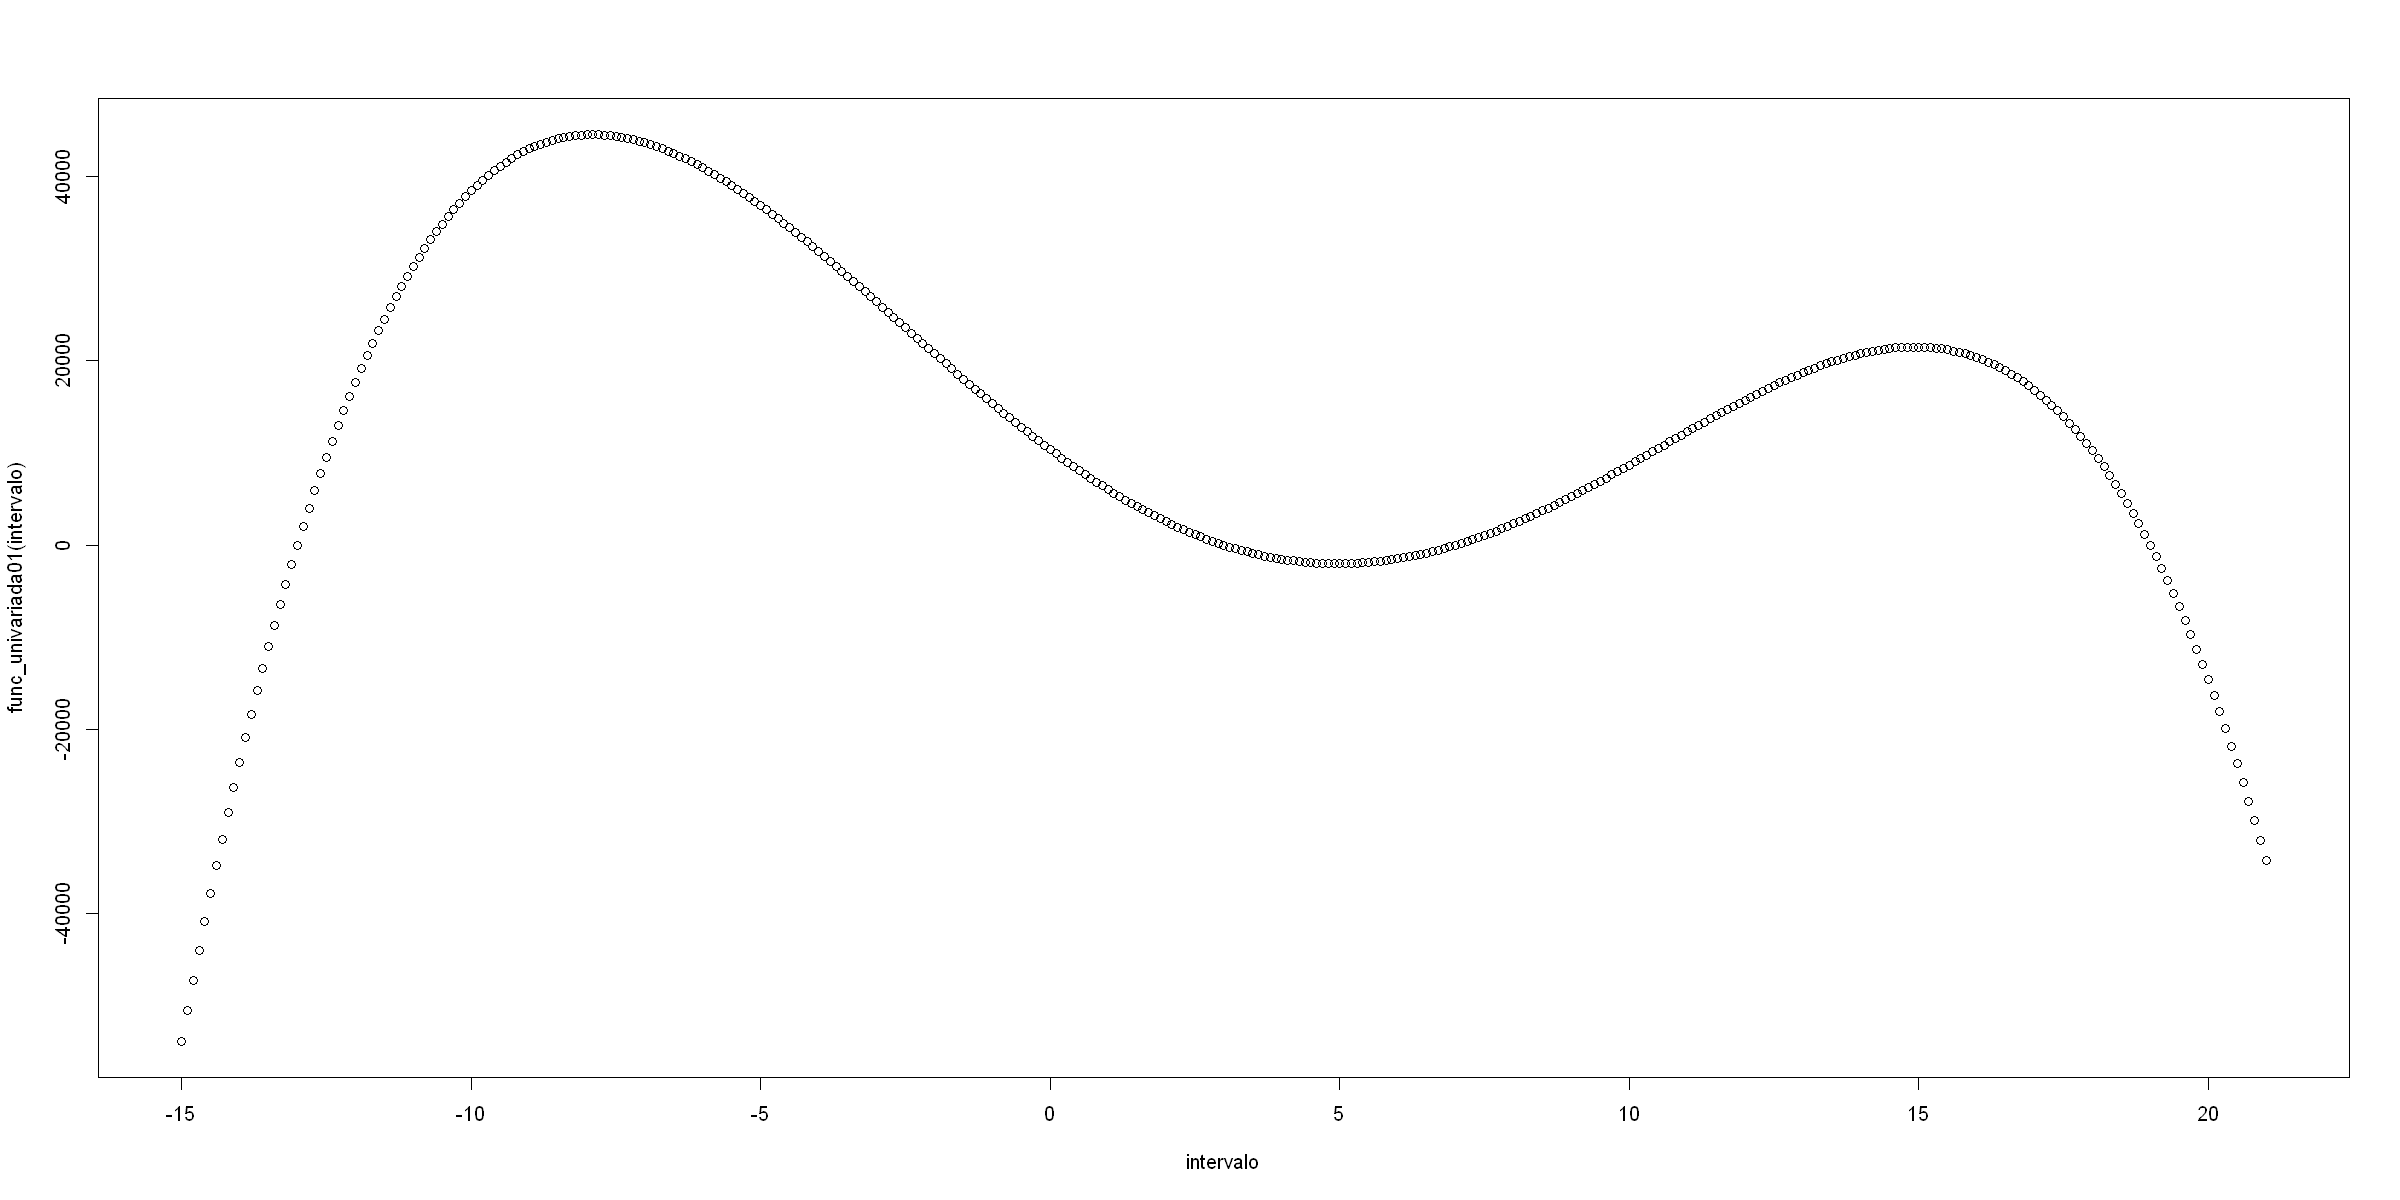

In [7]:
intervalo  <- seq(-15,21,0.1)
plot(intervalo, func_univariada01(intervalo))

La funcion tiene dos máximos, uno de ellos es el global.

### Optimizacion Bayesiana

¿Qué tan rápido encontrará la Optmización Bayesiana el máximo global?

Defino las caracteristicas de la optimizacion

* **fn**    es el nombre de la funcion
* **minimize**   por defecto es TRUE,  pero en este caso le asigno FALSE, ya que deseo maximizar  el valor
* **par.set**  indica cuales son los hiperparmetros de la funcion, en este caso hay una sola variable que llamé  x
---
* **makeNumericParam** indica que ese hiperparámetro es un numero real, una variable continua  ( no es ni un entero ni una categoria )

In [8]:
obj.fun  <- makeSingleObjectiveFunction(
              fn=       func_univariada01,
              minimize= FALSE,   #estoy Maximizando la ganancia
              par.set=  makeParamSet(  makeNumericParam( "x", lower= -100, upper=  100) ),
             )

ahora defino la funcion proxy, la que se construye internamente intentando emular la realidad

* **cl**  es la clase de learner,  "reg.km" indica el método de kriging "**reg**ression **k**riging **m**ethodd"
* **predict.type**  es el tipo de prediccion que deseo me devuelva, "se" significa que espero dos valores  media y standard error
* **covtype**    es la funcion de covarianza que se va a utilizar, cual es la covarianza de dos mediciones como fucion de la distancia entre los puntos donde fueron tomadas las mediciones, fue inventada por Bertil Matérn 

El método de kriging puede verse en su forma original (la geología) , esta presentación https://www.youtube.com/watch?v=ZB7GvJrNKq0

In [9]:
fproxy  <- makeLearner( cl= "regr.km",
                        predict.type= "se", 
                        covtype= "matern3_2" )

ultima definicion,  especificar la optimizacion bayesiana
*  **crit**   indica el criterio con el que se completan los valores iniciales "no inteligentes"
*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.

In [10]:
ctrl  <- makeMBOControl()
ctrl  <- setMBOControlInfill( ctrl, crit= makeMBOInfillCritEI())
ctrl  <- setMBOControlTermination( ctrl, iters= 25 )

finalmente , lanzo la Optimizacion Bayesiana

* **fun**  es la especificacion de la funcion que deseo optimizar, si maximizo o minimizo, cuales son las variables de la misma
* **learner**  especifica cual es la función proxy interna que va a utilizar la Optimziación Bayesiana
* **control**  indica la la forma en que se harán las iteraciones

In [11]:
run  <- mbo( fun=      obj.fun, 
             learner= fproxy, 
             control= ctrl )

Computing y column(s) for design. Not provided.

[mbo] 0: x=20.6 : y = -2.54e+04 : 0.0 secs : initdesign

[mbo] 0: x=-33.4 : y = -3.16e+06 : 0.0 secs : initdesign

[mbo] 0: x=81.6 : y = -6.95e+07 : 0.0 secs : initdesign

[mbo] 0: x=-64.3 : y = -4.1e+07 : 0.0 secs : initdesign




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -74.36511 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       74.365  |proj g|=   0.00055613
At iterate     1  f =       74.365  |proj g|=     0.0005558
At iterate     2  f =       74.365  |proj g|=     0.0001601
At iterate     3  f =       74.365  |proj g|=    8.0646e-05
At iterate     4  f =       74.365  |proj g|=    3.4464e-05
At iterate     5  f =       74.365  |proj g|=    1.6041e-05
At iterate     6  f =       74.365  |proj g|=    7.3449e-06
At iterate     7  f =       74.365  |proj g|=    3.4255e-06
At iterate     8  f =       74.365  |proj g|=    1.6016e-06
At iterate     9  f =       74.365 

[mbo] 1: x=18.6 : y = 4.18e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -90.40945 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       90.409  |proj g|=    0.0039656
At iterate     1  f =       90.409  |proj g|=      0.003961
At iterate     2  f =       90.402  |proj g|=    0.00040369
At iterate     3  f =       90.402  |proj g|=    4.7779e-05
At iterate     4  f =       90.402  |proj g|=    6.9201e-07
At iterate     5  f =       90.402  |proj g|=    1.2116e-09

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.21156e-09
final functio

[mbo] 2: x=-11.4 : y = 2.64e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -107.6942 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       107.69  |proj g|=    0.0094386
At iterate     1  f =       107.69  |proj g|=      0.009428
At iterate     2  f =       107.65  |proj g|=     0.0020911
At iterate     3  f =       107.65  |proj g|=    0.00060756
At iterate     4  f =       107.65  |proj g|=    5.9727e-05
At iterate     5  f =       107.65  |proj g|=    1.9462e-06
At iterate     6  f =       107.65  |proj g|=     6.508e-09

iterations 6
function evaluations 7
segments explored during Cauchy searches 6
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
no

[mbo] 3: x=-21.7 : y = -5e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -123.6346 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       123.63  |proj g|=    0.0028653
At iterate     1  f =       123.63  |proj g|=     0.0028641
At iterate     2  f =       123.62  |proj g|=    0.00041576
At iterate     3  f =       123.62  |proj g|=    7.1919e-05
At iterate     4  f =       123.62  |proj g|=    2.2848e-06
At iterate     5  f =       123.62  |proj g|=    1.3078e-08

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.30778e-08
final functio

[mbo] 4: x=2.59 : y = 933 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -139.5018 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        139.5  |proj g|=    0.0017164
At iterate     1  f =        139.5  |proj g|=     0.0017162
At iterate     2  f =       139.49  |proj g|=    0.00057597
At iterate     3  f =       139.49  |proj g|=    0.00012584
At iterate     4  f =       139.49  |proj g|=    7.2664e-06
At iterate     5  f =       139.49  |proj g|=    9.8853e-08

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 9.88532e-08
final functio

[mbo] 5: x=-4.45 : y = 3.42e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -154.2648 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       154.26  |proj g|=    0.0020463
At iterate     1  f =       154.26  |proj g|=      0.002046
At iterate     2  f =       154.25  |proj g|=    0.00033039
At iterate     3  f =       154.25  |proj g|=    6.4556e-05
At iterate     4  f =       154.25  |proj g|=    2.6529e-06
At iterate     5  f =       154.25  |proj g|=    2.2445e-08

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 2.24454e-08
final functio

[mbo] 6: x=10.2 : y = 9.55e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -168.9156 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       168.92  |proj g|=    0.0010601
At iterate     1  f =       168.92  |proj g|=       0.00106
At iterate     2  f =       168.91  |proj g|=     0.0001256
At iterate     3  f =       168.91  |proj g|=    1.7166e-05
At iterate     4  f =       168.91  |proj g|=    3.3318e-07
At iterate     5  f =       168.91  |proj g|=    9.0585e-10

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 9.05849e-10
final functio

[mbo] 7: x=-15.5 : y = -7.3e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -182.9409 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       182.94  |proj g|=   0.00045759
At iterate     1  f =       182.94  |proj g|=    0.00045757

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000457568
final function value 182.941

F = 182.941
final  value 182.940928 
converged


[mbo] 8: x=14.1 : y = 2.1e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -196.5281 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       196.53  |proj g|=   0.00018901
At iterate     1  f =       196.53  |proj g|=      0.000189

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000189001
final function value 196.528

F = 196.528
final  value 196.528096 
converged


[mbo] 9: x=-7.82 : y = 4.46e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -209.8207 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       209.82  |proj g|=   8.4481e-05
At iterate     1  f =       209.82  |proj g|=    8.4478e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 8.44781e-05
final function value 209.821

F = 209.821
final  value 209.820749 
converged


[mbo] 10: x=6.35 : y = -1.07e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -223.1777 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       223.18  |proj g|=   3.2603e-05
At iterate     1  f =       223.18  |proj g|=    3.2602e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 3.26016e-05
final function value 223.178

F = 223.178
final  value 223.177698 
converged


[mbo] 11: x=-1.07 : y = 1.57e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -236.3088 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       236.31  |proj g|=   0.00034718
At iterate     1  f =       236.31  |proj g|=    0.00034717

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000347171
final function value 236.309

F = 236.309
final  value 236.308821 
converged


[mbo] 12: x=-9.5 : y = 4.12e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -248.4865 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       248.49  |proj g|=   0.00085822
At iterate     1  f =       248.49  |proj g|=     0.0008582
At iterate     2  f =       248.48  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 248.48

F = 248.48
final  value 248.479575 
converged


[mbo] 13: x=16.2 : y = 1.98e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -260.9114 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       260.91  |proj g|=     0.001419
At iterate     1  f =       260.91  |proj g|=     0.0014189
At iterate     2  f =        260.9  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 260.903

F = 260.903
final  value 260.902501 
converged


[mbo] 14: x=-6.16 : y = 4.15e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -272.8871 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       272.89  |proj g|=     0.002031
At iterate     1  f =       272.89  |proj g|=     0.0020309
At iterate     2  f =       272.88  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 272.876

F = 272.876
final  value 272.875683 
converged


[mbo] 15: x=12.2 : y = 1.64e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -285.0963 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        285.1  |proj g|=    0.0031632
At iterate     1  f =        285.1  |proj g|=      0.003163
At iterate     2  f =       285.05  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 285.05

F = 285.05
final  value 285.049971 
converged


[mbo] 16: x=-2.82 : y = 2.54e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -296.9813 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       296.98  |proj g|=     0.003064
At iterate     1  f =       296.98  |proj g|=     0.0030639
At iterate     2  f =       296.98  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 296.98

F = 296.98
final  value 296.979868 
converged


[mbo] 17: x=-13.2 : y = -3.24e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -309.3598 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       309.36  |proj g|=    0.0059571
At iterate     1  f =       309.36  |proj g|=     0.0059566
At iterate     2  f =       309.18  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 309.183

F = 309.183
final  value 309.182677 
converged


[mbo] 18: x=8.29 : y = 3.12e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -321.3912 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       321.39  |proj g|=    0.0057815
At iterate     1  f =       321.39  |proj g|=     0.0057811
At iterate     2  f =       321.27  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 321.268

F = 321.268
final  value 321.267897 
converged


[mbo] 19: x=0.743 : y = 7.09e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -333.2587 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       333.26  |proj g|=    0.0051837
At iterate     1  f =       333.26  |proj g|=     0.0051834
At iterate     2  f =       333.23  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 333.233

F = 333.233
final  value 333.233386 
converged


[mbo] 20: x=25.1 : y = -1.87e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -348.2137 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       348.21  |proj g|=    0.0058653
At iterate     1  f =       348.21  |proj g|=     0.0058649
At iterate     2  f =       348.17  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 348.166

F = 348.166
final  value 348.166346 
converged


[mbo] 21: x=22.8 : y = -8.41e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -360.7581 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       360.76  |proj g|=    0.0068942
At iterate     1  f =       360.76  |proj g|=     0.0068936
At iterate     2  f =       360.67  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 360.668

F = 360.668
final  value 360.667726 
converged


[mbo] 22: x=4.47 : y = -1.89e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -372.6992 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        372.7  |proj g|=    0.0075079
At iterate     1  f =        372.7  |proj g|=     0.0075073
At iterate     2  f =       372.61  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 372.605

F = 372.605
final  value 372.605369 
converged


[mbo] 23: x=-8.63 : y = 4.39e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -383.574 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       383.57  |proj g|=    0.0085922
At iterate     1  f =       383.57  |proj g|=     0.0085914
At iterate     2  f =       383.43  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 383.431

F = 383.431
final  value 383.431137 
converged


[mbo] 24: x=-7 : y = 4.37e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -394.1736 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       394.17  |proj g|=    0.0079068
At iterate     1  f =       394.17  |proj g|=     0.0079061
At iterate     2  f =       394.16  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 394.157

F = 394.157
final  value 394.157245 
converged


[mbo] 25: x=-10.3 : y = 3.62e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  291.8642 
  - best initial criterion value(s) :  -405.0935 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       405.09  |proj g|=    0.0092055
At iterate     1  f =       405.09  |proj g|=     0.0092047
At iterate     2  f =       405.01  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 405.006

F = 405.006
final  value 405.005566 
converged


In [12]:
tb_resultados  <- as.data.table( run$opt.path )

In [13]:
tb_resultados

x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
20.584777,-2.542905e+04,0,NA,NA,0.01,NA,NA,NA,initdesign,NA,NA,NA
-33.429375,-3.155067e+06,0,NA,NA,0.00,NA,NA,NA,initdesign,NA,NA,NA
81.622322,-6.952922e+07,0,NA,NA,0.00,NA,NA,NA,initdesign,NA,NA,NA
-64.309776,-4.103489e+07,0,NA,NA,0.00,NA,NA,NA,initdesign,NA,NA,NA
18.636565,4.184200e+03,1,NA,NA,0.00,-4620652.888,NA,0.03,infill_ei,0.16,21306117.56,-9405218.9573
-11.351147,2.635948e+04,2,NA,NA,0.00,-6249167.412,NA,0.00,infill_ei,0.16,14630268.98,811486.0654
-21.677583,-4.996076e+05,3,NA,NA,0.00,-1832497.263,NA,0.01,infill_ei,0.14,3869660.86,573050.4207
2.586990,9.325595e+02,4,NA,NA,0.00,-1412317.759,NA,0.02,infill_ei,0.14,3468403.98,83236.9208
-4.453966,3.422585e+04,5,NA,NA,0.00,-470644.293,NA,0.00,infill_ei,0.15,1111785.04,79556.6688


In [14]:
tb_resultados[ which.max( tb_resultados$y ) ]

x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-7.818863,44554.54,9,NA,NA,0,-102452.9,NA,0.02,infill_ei,0.14,246097.1,42659.2


### Conclusiones

La gran pregunta es :  la Optimización Bayesiana, ¿se focaliza luego de muchas iteraciones solo en el entorno del máximo que está cerca de x= -8 ?